# FMCW Intro

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Intro_nb.ipynb)

Below is an intro to mmWrt for simple targets position estimation

### linear chirps and IF frequencies

Signal model
According to (Barriok 1973; Stove 1992; Komarov and Smolskiy 2003; Winkler 2007) the
transmitted signal of an FMCW radar system can be modeled as
where 

$$ y_T (t) = A_T \cdot cos ( 2 \pi \cdot (f_{0min} + s\cdot t) \cdot t $$ 


Where:

* $\text{f}_{0min}$ is the start frequency at the begining of the raising frequency of the chirp.
* s is the slope at which the frequency is ramped ( $S = \frac{B}{T}$)
* B is the total bandwdith of the chirp
* T is the total time of the chirp

Considering a reflected signal with a time delay $\delta = 2 · \frac{R0+ v\cdot t}{c}$

Where:

* c is the speed of light
* R0 is the nominal distance to the target
* $\delta$ is the time of flight (to and from the target)
* v is radial the velocity of the target

The receive signal $y_R(t)$ can be written as : 

$$ y_R(t) = A_R \cdot cos ( 2\pi \cdot (f_{0min} + s\cdot (t-\delta)) \cdot (t-\delta)) $$ 


$y_{IF}(t)$ is the IF signal (after mixer) which is obtained by multiplication in the time domain, and passed to a low-pass filter (LPF)

This can be done easily when remembering the trigonometric relation:

$$ cos(\alpha) \cdot cos(\beta) = \frac{cos(\alpha + \beta) + cos(\alpha - \beta)}{2} $$

$$ y_{IF}(t) = y_R(t) \cdot y_T(t) $$

Noticing that the element which sums the elements will be higher frequency and will be filtered by the LPF, it remains that:

$$ y_{IF}(t) = \frac{A_t \cdot A_r}{2} \cdot cos(2 \pi \cdot [f_{0min} \cdot \delta + s \cdot \delta \cdot t - s \cdot \delta^2])$$ 

Where:

* $f_{0min}$ the starting frequency of the chirp
* s is the slope of the chirp
* $\delta$ is the total time of flight between antennas and target
* At, Ar: Amplitude of the RX and TX waves

In [13]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install mmWrt

^C


In [5]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402


synthetic targets [(1.5, 0, 0), (5, 0, 0)]
found targets [(1.5090543259557343, 0, 0), (4.979879275653924, 0, 0)]
error is 0.029175050301810224


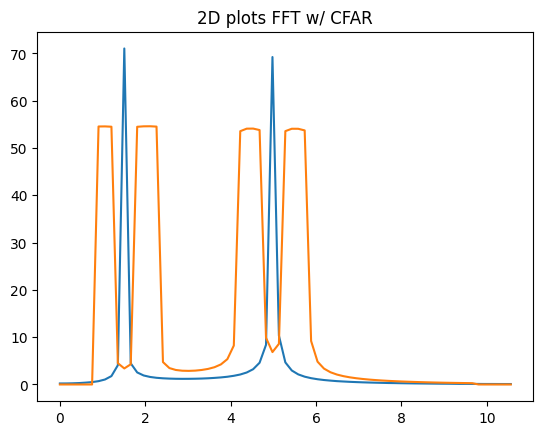

In [16]:
c = 3e8

debug_ON = True
test = 0
radar = Radar(transmitter=Transmitter(bw=1e9, slope=70e8),
              receiver=Receiver(fs=1e3, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(1.5)
target2 = Target(5, 0, 0, vx=lambda t: 2*t+0)
# below is also an equivalent definition of target2
# as at t=0 the position will be x0=2+3=5
# target2 = Target(2, 0, 0, vx=lambda t: 2*t+3)
targets = [target1, target2]

bb = rt_points(radar, targets, debug=debug_ON)
Distances, range_profile = rsp.range_fft(bb)
ca_cfar = rsp.cfar_ca_1d(range_profile)

mag_r = abs(range_profile)
mag_c = abs(ca_cfar)
# little hack to remove small FFT ripples : mag_r> 5
target_filter = ((mag_r > mag_c) & (mag_r > 5))

index_peaks = where(target_filter)[0]
grouped_peaks = rsp.peak_grouping_1d(index_peaks)

found_targets = [Target(Distances[i]) for i in grouped_peaks]
error = rsp.error([target1, target2], found_targets)
print("synthetic targets", [t.pos() for t in targets])
print("found targets", [t.pos() for t in found_targets])
print("error is", error)

# 2D representation of the FFT and CFAR
# plot on X,Y axis the FFT and CFAR
plt.plot(Distances, mag_r)
plt.plot(Distances, mag_c)
plt.title("2D plots FFT w/ CFAR")
plt.show()

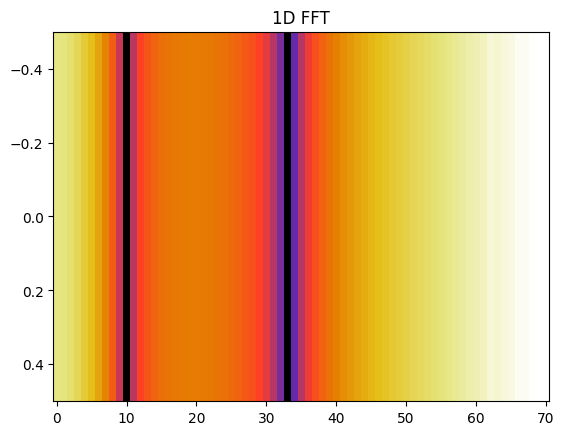

In [17]:
# 1D representation of the FFT
# useful later on to show the link between 1D FFT and 2D FFTs

# Select the color map named CMRmap_r
cmap = cm.get_cmap(name='CMRmap_r')
# convert the 1D array in 2D array to plot using imshow
mag_r = expand_dims(mag_r, axis=0)
# set aspect ratio to auto to have high enough pixels to see them in the y_axis
# change the norm to have a log color scale
# to better see the peaks in correlation with 2D FFT plot
plt.imshow(mag_r, cmap,
           aspect='auto',
           norm=colors.LogNorm(vmin=min(mag_r[0][:]), vmax=max(mag_r[0][:])))
plt.title("1D FFT")
# plt.savefig(fp_fft_1D)
plt.show()